# Reprodução gráfico EPRI
Teste para a rotina Risco_Kcs.py 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, pi
from scipy.stats import norm
from scipy.integrate import quad

In [7]:
def pdfSob(v:float, s2:float, ss:float) -> float: # F(V)
    # s2 corresponde a V2 --> S2 = S(1 + 2.05 sigma_s)
    s = s2 / (1 + 2.05 * ss) # Aqui está deslocado?
    return 1./(ss * sqrt(2*pi)) * exp(-0.5 * ((v-s)/ss)**2)

def cdfSup(v:float, v50:float, sf:float) -> float: # Eq. 5.13-1: P(V)
    it = quad(lambda x: exp(-0.5 * ((x-v50)/sf)**2), -np.inf, v)
    return 1./(sf*sqrt(2*pi)) * it[0]

def cdfSupN(n:int, v:float, v50:float, sf:float) -> float: # Eq. 5.13-8: P(N,V)
    return 1. - (1. - cdfSup(v, v50, sf))**n

def RISCO(Kcs, Ngaps, sig, sig_S):    
    #SOBRETENSÕES:
    V50 = 1                   # valor médio (pu)
    V2  = V50*(1+2.05*sig_S)  # máxima estatística 2% (pu)
    
    #SUPORTABILIDADE:
    # Na proposta NBR 5422, está se utilizando U90, aqui fez U50 para bater com a referência.
    U50 = Kcs*V2            #tensão com 90% de probabilidade de descarga (pu)
    #U90 = Kcs*v2
    #U50 = U90/(1-1.28*sig)  #tensão com 50% de probabilidade de descarga (pu)
    
    #VETORES:
    umin = V50*(1-5*sig_S)
    umax = U50*(1+5*sig)
    du = 0.001
    u = np.arange(umin, umax, du)
    sob = norm.pdf(u,V50,V50*sig_S)
    sup = norm.cdf(u,U50,U50*sig)    
    ris = sob*(1-(1-sup)**Ngaps)
    return(sum(ris) * du) # Eq. 5.13-9

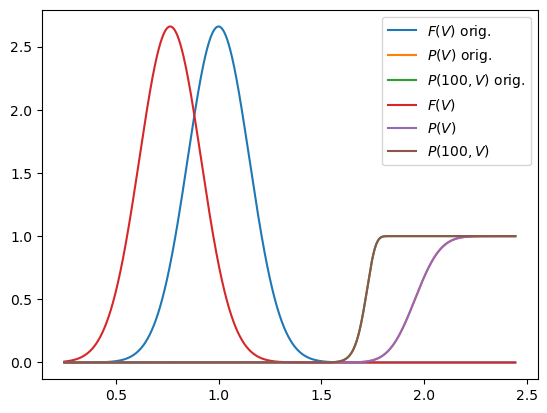

In [26]:
# Reprodução da figura 5.13-1
# Batendo a definição das distribuições com as fórmulas no EPRI
Kcs = 1.4
Ngaps = 1
sig = 0.05
sig_S = 0.15
V50 = 1
V2  = V50*(1+2.05*sig_S)
U90 = Kcs*V2            #tensão com 90% de probabilidade de descarga (pu)
U50 = U90/(1-1.28*sig)  #tensão com 50% de probabilidade de descarga (pu)
umin = V50*(1-5*sig_S)
umax = U50*(1+5*sig)
du = 0.001
u = np.arange(umin, umax, du)
sob = norm.pdf(u,V50,V50*sig_S)
sup = norm.cdf(u,U50,U50*sig)
supn = 1 - (1 - sup)**100

sob2 = np.zeros(len(u))
sup2 = np.zeros(len(u))
supn2 = np.zeros(len(u))
for i,uu in enumerate(u):
    sob2[i] = pdfSob(uu, V50, V50*sig_S)
    sup2[i] = cdfSup(uu, U50, U50*sig)
    supn2[i] = cdfSupN(100, uu, U50, U50*sig)

plt.figure()
plt.plot(u, sob, u, sup, u, supn, u, sob2, u, sup2, u, supn2)
plt.legend([r'$F(V)$ orig.', r'$P(V)$ orig.', r'$P(100,V)$ orig.', r'$F(V)$', r'$P(V)$', r'$P(100,V)$'])

In [20]:
# Reprodução da figura 5.13-2
K = np.arange(1,1.80,0.01) # coeficiente estatístico: R = CFO/S_2
DP   = [0.05] # desvio-padrão das sobretensões   (pu do valor médio)
DP_S = [0.05, 0.10, 0.15] # desvio-padrão da suportabilidade (pu do valor médio)
N  = [10,100,1000] # número de gaps em paralelo
cor = ['blue', 'green', 'red']
linha = [':','--','-'] # Estilo da linha

R = np.zeros((len(K), len(N), len(DP), len(DP_S)))
for i,Kcs in enumerate(K):
    for j,Ngaps in enumerate(N):
        for m,sigma in enumerate(DP):
            for n,sigma_S in enumerate(DP_S):
                R[i,j,m,n] = RISCO(Kcs, Ngaps, sigma, sigma_S)

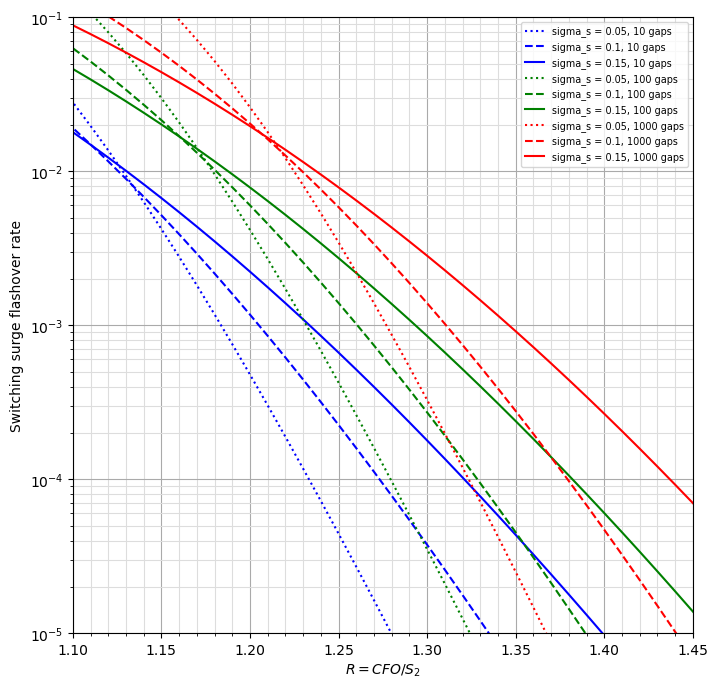

In [22]:
leg = []
plt.figure(figsize=[8,8])
for j in range(len(N)):
    for k in range(len(DP_S)):
        plt.plot(K,R[:,j,0,k], color=cor[j], linestyle=linha[k])
        leg.append(r'sigma_s = '+str(DP_S[k])+', '+str(N[j])+' gaps')
plt.yscale('log')
plt.xticks(np.arange(1.,1.70,0.05))
plt.xticks(np.arange(1.,1.70,0.01), minor=True)
plt.axis([1.1,1.45,1e-5,1e-1])
plt.grid(which='major', color='#AAAAAA')
plt.grid(which='minor', color='#DDDDDD')
plt.xlabel(r'$R=CFO/S_2$')
plt.ylabel('Switching surge flashover rate')
plt.legend(leg,fontsize='x-small')

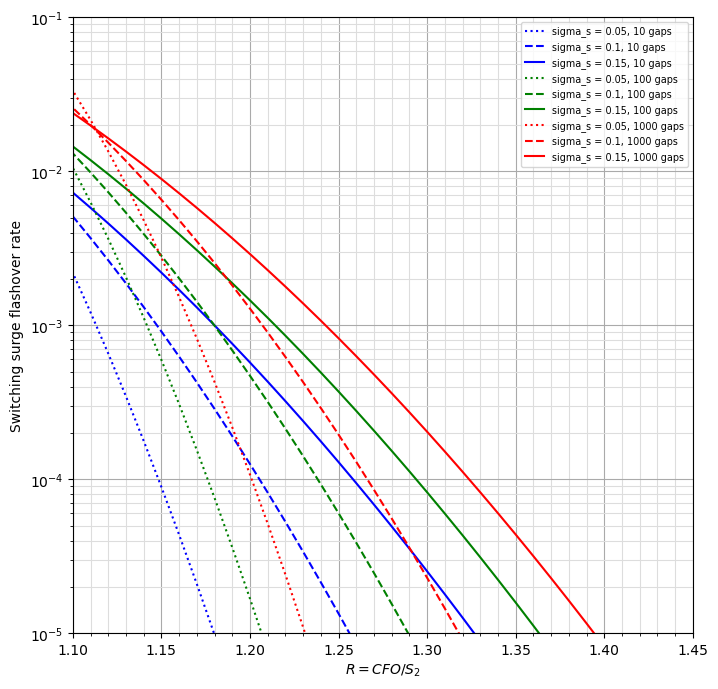

In [19]:
# Reprodução da figura 5.13-3
K = np.arange(1,1.80,0.01) # coeficiente estatístico R = CFO/S_2
DP   = [0.03]
DP_S = [0.05, 0.10, 0.15] # desvio-padrão da suportabilidade (pu do valor médio)
N  = [10,100,1000] # número de gaps em paralelo

R = np.zeros((len(K), len(N), len(DP), len(DP_S)))
for i,Kcs in enumerate(K):
    for j,Ngaps in enumerate(N):
        for m,sigma in enumerate(DP):
            for n,sigma_S in enumerate(DP_S):
                R[i,j,m,n] = RISCO(Kcs, Ngaps, sigma, sigma_S)
leg = []
plt.figure(figsize=[8,8])
for j in range(len(N)):
    for k in range(len(DP_S)):
        plt.plot(K,R[:,j,0,k], color=cor[j], linestyle=linha[k])
        leg.append(r'sigma_s = '+str(DP_S[k])+', '+str(N[j])+' gaps')
plt.yscale('log')
plt.xticks(np.arange(1.,1.70,0.05))
plt.xticks(np.arange(1.,1.70,0.01), minor=True)
plt.axis([1.1,1.45,1e-5,1e-1])
plt.grid(which='major', color='#AAAAAA')
plt.grid(which='minor', color='#DDDDDD')
plt.xlabel(r'$R=CFO/S_2$')
plt.ylabel('Switching surge flashover rate')
plt.legend(leg,fontsize='x-small')